# Loading data and working with grandPy objects

<span style="color:green">Notiz: alles was rot ist, ist noch nicht umgesetzt oder müsste noch überarbeitet werden durch Links etc.</span>

GrandPy is a Python package for the analysis of RNA-seq experiments involving metabolic RNA labeling with nucleotide conversion, such as SLAM-seq experiments [[1]](https://www.nature.com/articles/nmeth.4435). In such experiments, nucleoside analogs such as 4sU are added to living cells, which take it up and incorporate it into newly synthesized RNA. Before sequencing, 4sU is converted into a cytosin analog. Reads covering 4sU sites therefore have characteristic T-to-C mismatches after read mapping, in principle providing the opportunity to differentiate newly synthesized (during the time of labeling) from preexisting RNA.

Confounders such as sequencing errors or read that originate from newly synthesized RNA but, by chance, do not cover sites of 4sU incorporation (usually 20-80% of all "new read") can be handled using specialized methods such as GRAND-SLAM [[2]](https://academic.oup.com/bioinformatics/article/34/13/i218/5045735?login=true).

# Reading in the data

Throughout this vignette, we will be using the GRAND-SLAM processed SLAM-seq data set from Finkel et al.2021 [[3]](https://www.nature.com/articles/s41586-021-03610-3). The data set contains time series (progressive labeling) samples from a human epithelial cell line (Calu3 cells); half of the samples were infected with SARS-CoV-2 for different periods of time.

The output of GRAND-SLAM is a tsv file where rows are genes and columns are read counts and other statistics (e.g., the new-to-total RNA ratio) for all samples. The data set is available on zenodo ("https://zenodo.org/record/5834034/files/sars.tsv.gz"). We start by reading this file into Python:

In [1]:
# Package installation
from Py.load import *
sars = read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz", design=("Condition", "dur.4sU", "Replicate"))
print(sars.columns)

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file sars.tsv.gz was deleted after loading.
['Mock.no4sU.A', 'Mock.1h.A', 'Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A', 'SARS.no4sU.A', 'SARS.1h.A', 'SARS.2h.A', 'SARS.2h.B', 'SARS.3h.A', 'SARS.4h.A']


C:\Users\User\PycharmProjects\grandpy\Py\utils.py:140: UserWarning: 17 Duplicate gene symbols found: STPG4, PDE11A, TXNRD3NB, ARL14EPL, HIST1H3D (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).
  warnings.warn(f"{len(duplicates_list)} Duplicate gene symbols found: {', '.join(duplicates_list[:5])} (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).")


When reading in the file, we have to define the `design` vector. This is used to infer metadata automatically from sample names. Here sample names consist of three parts separated by dots as shown above (the Columns function returns the sample names or cell ids when analyzing a single cell data set). Each part in the sample name represents an aspect of the design. For example, the sample named Mock.2h.A is a sample from the mock condition (i.e. not infected by SARS-CoV-2), subjected to metabolic labeling for 2 hours, and is the first replicate (i.e. replicate "A"). This sample name is consistent with the three element design vector used above. It is possible to specify other design elements (of course the samples would have to be named accordingly). A list of reasonable options is predefined in the dictionary `DESIGN_KEYS`.

There are names (i.e. the things you specify in the design vector) that have additional semantics. For example, for the name `duration.4sU` the values are interpreted like this: 4h is converted into the number 4, 30min into 0.5, and no4sU into 0. For more information, see Paragraph *Column Metadata*). The design vector is mandatory. Attempting to read in the data without it results in an error:

In [2]:
sars_wrong = read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz")

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
ValueError: Design must be specified.
Temporary file sars.tsv.gz was deleted after loading.


C:\Users\User\PycharmProjects\grandpy\Py\utils.py:140: UserWarning: 17 Duplicate gene symbols found: STPG4, PDE11A, TXNRD3NB, ARL14EPL, HIST1H3D (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).
  warnings.warn(f"{len(duplicates_list)} Duplicate gene symbols found: {', '.join(duplicates_list[:5])} (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).")


Alternatively, a table containing the metadata can be specified. Make sure that it contains a `Name` column matching the names in the GRAND-SLAM output table:

In [3]:
import pandas as pd
metadata = pd.DataFrame({
    "Name": [
        "Mock.no4sU.A","Mock.1h.A","Mock.2h.A","Mock.2h.B",
        "Mock.3h.A","Mock.4h.A","SARS.no4sU.A","SARS.1h.A",
        "SARS.2h.A","SARS.2h.B","SARS.3h.A","SARS.4h.A"
    ],
    "Condition": ["Mock"] * 6 + ["SARS"] * 6
})

sars_meta = read_grand("../data/sars.tsv", design=metadata)
print(sars_meta)

#TODO: Warning??

Detected dense format -> using dense reader
GrandPy:
Read from sars
19659 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count']
Available analyses: []
Available plots: {}
Default data slot: count



C:\Users\User\PycharmProjects\grandpy\Py\utils.py:140: UserWarning: 17 Duplicate gene symbols found: STPG4, PDE11A, TXNRD3NB, ARL14EPL, HIST1H3D (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).
  warnings.warn(f"{len(duplicates_list)} Duplicate gene symbols found: {', '.join(duplicates_list[:5])} (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).")
C:\Users\User\PycharmProjects\grandpy\.venv\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# What is the grandPy object

`read_grand` returns a grandPy object, which contains

1. metadata for genes
2. metadata for samples/cells (as inferred from the sample names by the design parameter)
3. all data matrices (counts, normalized counts, ntrs, etc. these types of data are called "slots")
4. analysis results

Metadata (1. and 2.) are described below. How to work with the data matrices and analysis results is described in a separate [vignette](vignette_04_working_with_data_matrices_and_analysis_results.ipynb).

# Working with grandPy objects

Here we will see how to work with grandPy objects in general. A short summary can be displayed when `print`ing the object, and there are several functions to retrieve general information about the object:

In [4]:
print(sars)

GrandPy:
Read from sars.tsv
19659 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count']
Available analyses: []
Available plots: {}
Default data slot: count



In [5]:
print(sars.title)

sars.tsv


In [6]:
print(len(sars.genes))

19659


In [7]:
print(len(sars.coldata))

12



It is straight-forward to filter genes:

In [8]:
# Anpassen
from Py.processing import _filter_genes
sars = _filter_genes(sars)
print(len(sars.genes))

9162


By default genes are retained if they have 100 read counts in at least half of the samples (or cells). There are many options how to filter by genes (note that `filter_genes` returns a new grandPy object, and below we directly call `len()` on this new object to check how many genes are retained by filtering):

In [9]:
print(f"Genes with at least 1000 read counts in half of the columns: {len((_filter_genes(sars, min_expression=1000, return_genes=True)))}")

Genes with at least 1000 read counts in half of the columns: 1528


In [10]:
print(f"Genes with at least 1000 read counts in half of the columns (retain two genes that are otherwise filtered): {len((_filter_genes(sars, min_expression=1000, keep=["ATF3", "ZC3H12A"], return_genes=True)))}")

Genes with at least 1000 read counts in half of the columns (retain two genes that are otherwise filtered): 1530


In [11]:
print(f"Keep only these two genes: {len((_filter_genes(sars, use=["ATF3", "ZC3H12A"],return_genes=True)))}")

Keep only these two genes: 2


In [12]:
sars = sars.normalize_tpm()
print("Genes with at least 10 TPM in half of the columns:", len(_filter_genes(sars,mode_slot="tpm", min_expression=10, min_columns=sars.coldata.shape[0]/2, return_genes=True)))


Genes with at least 10 TPM in half of the columns: 7795


`_filter_genes` essentially removes rows from the data slots. It is also possible to remove columns (i.e. samples or cells). See this example:

In [13]:
mock = sars[:, sars.coldata["Condition"] == "Mock"]
print(mock)

GrandPy:
Read from sars.tsv
9162 genes, 6 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'tpm']
Available analyses: []
Available plots: {}
Default data slot: tpm



The new grandPy object now only has 6 columns. The `columns`parameter to subset must be a logical vector, and you can use the names of the column metadata table (see below) as variables (i.e. the parameter here is a logical vector with all samples being TRUE where the `Condition` column is equal to "Mock".

A closely related function is `split`, which returns a list of several grandPy objects, each composed of samples having the same `Condition`.</span>

In [14]:
object1, object2 = sars.split(by="Condition")
print(object1, "\n", object2)

GrandPy:
Read from sars.tsv
9162 genes, 6 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'tpm']
Available analyses: []
Available plots: {}
Default data slot: tpm
 
 GrandPy:
Read from sars.tsv
9162 genes, 6 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'tpm']
Available analyses: []
Available plots: {}
Default data slot: tpm



In [15]:
print(object1.columns, "\n", object2.columns)

['Mock.no4sU.A', 'Mock.1h.A', 'Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A'] 
 ['SARS.no4sU.A', 'SARS.1h.A', 'SARS.2h.A', 'SARS.2h.B', 'SARS.3h.A', 'SARS.4h.A']


The inverse of `split` is `merge`:

In [16]:
sars_mock = object1.merge(object2, axis=0)
print(sars_mock.columns)

['Mock.no4sU.A', 'Mock.1h.A', 'Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A', 'SARS.no4sU.A', 'SARS.1h.A', 'SARS.2h.A', 'SARS.2h.B', 'SARS.3h.A', 'SARS.4h.A']


`concat` can also be used, see below:

In [17]:
# TODO: fix imports ... next sprint
# import grandpy as gp zu beginn von der file
# print(gp.concat([object1, object2]))

Note that we merged such that now we have first the SARS samples and then the Mock samples. We can also do it another way (see below):

In [18]:
object1 = sars[:,sars.coldata["Condition"] == "Mock"]
object2 = sars[:,sars.coldata["Condition"] == "SARS"]

print(object1.columns, "\n", object2.columns)

['Mock.no4sU.A', 'Mock.1h.A', 'Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A'] 
 ['SARS.no4sU.A', 'SARS.1h.A', 'SARS.2h.A', 'SARS.2h.B', 'SARS.3h.A', 'SARS.4h.A']


# Gene metadata

Here we see how to work with metadata for genes. The gene metadata essentially is a table that can be retrieved using the `gene_info` function:

In [19]:
print(sars.gene_info.head(10))

# Ausgabe eig von 27 - 47 und nach Länge sortiert?

          Symbol             Gene  Length      Type
Symbol                                             
MIB2        MIB2  ENSG00000197530    4247  Cellular
OSBPL9    OSBPL9  ENSG00000117859    4520  Cellular
BTF3L4    BTF3L4  ENSG00000134717    4703  Cellular
ZFYVE9    ZFYVE9  ENSG00000157077    5194  Cellular
PRPF38A  PRPF38A  ENSG00000134748    5274  Cellular
AHCYL1    AHCYL1  ENSG00000168710    4313  Cellular
ADGRL2    ADGRL2  ENSG00000117114    6302  Cellular
HOOK1      HOOK1  ENSG00000134709    5857  Cellular
NFIA        NFIA  ENSG00000162599    9487  Cellular
PATJ        PATJ  ENSG00000132849    8505  Cellular


Each gene has associated gene ids and symbols. Gene ids and symbols as well as the transcript length are part of GRAND-SLAM output. The `TRype` column is inferred automatically (see below).

Genes can be identified with the `genes` & `get_genes` functions:

In [20]:
print(sars.genes[:20])

['MIB2', 'OSBPL9', 'BTF3L4', 'ZFYVE9', 'PRPF38A', 'AHCYL1', 'ADGRL2', 'HOOK1', 'NFIA', 'PATJ', 'VANGL1', 'GPR89B', 'GPSM2', 'ARHGEF10L', 'TMEM50A', 'TMEM57', 'ZNF593', 'RNF207', 'ZNF362', 'STX12']


In [21]:
print(sars.get_genes(get_gene_symbols=False)[:20])

['ENSG00000197530', 'ENSG00000117859', 'ENSG00000134717', 'ENSG00000157077', 'ENSG00000134748', 'ENSG00000168710', 'ENSG00000117114', 'ENSG00000134709', 'ENSG00000162599', 'ENSG00000132849', 'ENSG00000173218', 'ENSG00000188092', 'ENSG00000121957', 'ENSG00000074964', 'ENSG00000183726', 'ENSG00000204178', 'ENSG00000142684', 'ENSG00000158286', 'ENSG00000160094', 'ENSG00000117758']


In [22]:
print(sars.get_genes(genes=["MYC", "ORF1ab"],get_gene_symbols=False)[:20])

['ENSG00000136997', 'ORF1ab']


In [23]:
print(sars.get_genes(genes="YC", regex=True))

['NFYC', 'MYCBP', 'PYCR2', 'GLYCTK', 'FYCO1', 'CYCS', 'CYC1', 'MYC', 'PYCR3', 'MYCBP2', 'MLYCD', 'PYCR1', 'SYCP2']


During reading the data into Python using `read_grand`, the `Type` column is inferred using the `classify_genes` function. By default, this will recognize mitochondrial genes (MT prefix of the gene symbol), ERCC spike-ins, and Ensembl gene identifiers (which it will call "cellular"). Here we also have the viral genes, which are not properly recognized:

In [24]:
print(pd.DataFrame(sars.gene_info["Type"].value_counts()).T)

Type   Cellular  Unknown
count      9151       11


If you want to define your own types, you can do this easily by specifying the `classify_genes` parameter when read in your data:

In [25]:
viral_genes = ['ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10','ORF1ab','S']
sars = read_grand("../data/sars.tsv", design=("Condition", "dur.4sU", "Replicate"), classification_genes=viral_genes, classification_genes_label="viral")

print(pd.DataFrame(sars.gene_info["Type"].value_counts()).T)

Detected dense format -> using dense reader
Type   Cellular  viral
count     19648     11


C:\Users\User\PycharmProjects\grandpy\Py\utils.py:140: UserWarning: 17 Duplicate gene symbols found: STPG4, PDE11A, TXNRD3NB, ARL14EPL, HIST1H3D (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).
  warnings.warn(f"{len(duplicates_list)} Duplicate gene symbols found: {', '.join(duplicates_list[:5])} (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).")


Note that each parameter to `classify_genes` must be named (`viral`) and must be a function that takes the gene metadata table and returns a logical vector.

The `classify_genes` function has one additional important parameter, which defines how "Unknown" types are supposed to be called. For this data set, a similar behavior as above can be accomplished by:

In [26]:
sars = read_grand("../data/sars.tsv", design=("Condition", "dur.4sU", "Replicate"), classify_genes_func=lambda df: classify_genes(df, name_unknown="viral"))

print(pd.DataFrame(sars.gene_info["Type"].value_counts()).T)

Detected dense format -> using dense reader
Type   Cellular  viral
count     19648     11


C:\Users\User\PycharmProjects\grandpy\Py\utils.py:140: UserWarning: 17 Duplicate gene symbols found: STPG4, PDE11A, TXNRD3NB, ARL14EPL, HIST1H3D (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).
  warnings.warn(f"{len(duplicates_list)} Duplicate gene symbols found: {', '.join(duplicates_list[:5])} (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).")


It is also straight-forward to add additional gene metadata:

In [27]:
sars = sars.with_gene_info("length.category", pd.cut(
    sars.gene_info["Length"],
    bins=[0, 2000, 5000, float("inf")],
    labels=["Short", "Medium", "Long"]
))

print(pd.DataFrame(sars.gene_info["length.category"].value_counts()).T)

# die Reihenfolge ist nicht perfekt

length.category  Medium  Short  Long
count              9517   5511  4631


# Column Metadata

Samples for bulk experiments and cells in single cell experiments are in grandR jointly called "columns". The metadata for columns is a table that describes the experimental design we specified when reading in data in grandPy. It can be accessed via the `coldata` function. We can also see that the duration of 4sU has been interpreted and converted to a numeric value (compare "dur.4sU" with "dur.4sU.original").

In [28]:
print(sars.coldata)

                      Name Condition  duration.4sU duration.4sU.original  \
Name                                                                       
Mock.no4sU.A  Mock.no4sU.A      Mock           0.0                 no4sU   
Mock.1h.A        Mock.1h.A      Mock           1.0                    1h   
Mock.2h.A        Mock.2h.A      Mock           2.0                    2h   
Mock.2h.B        Mock.2h.B      Mock           2.0                    2h   
Mock.3h.A        Mock.3h.A      Mock           3.0                    3h   
Mock.4h.A        Mock.4h.A      Mock           4.0                    4h   
SARS.no4sU.A  SARS.no4sU.A      SARS           0.0                 no4sU   
SARS.1h.A        SARS.1h.A      SARS           1.0                    1h   
SARS.2h.A        SARS.2h.A      SARS           2.0                    2h   
SARS.2h.B        SARS.2h.B      SARS           2.0                    2h   
SARS.3h.A        SARS.3h.A      SARS           3.0                    3h   
SARS.4h.A   

Additional semantics can also be defined. This is done using the function `apply_design_semantics`, which creates a dictionary for the attribute `.attrs[“_semantics”]` in the `coldata` DataFrame. This dictionary is used to interpret design columns (e.g. time, concentration). The function `apply_design_semantics` is called automatically in `build_coldata()`.

An important component here is that certain column contents (e.g. time specifications such as '5h' or '30min') can be converted into numerical values. There is already a predefined function `parse_time_string` in `grandPy` for this purpose:

In [29]:
print(semantics_time(["5h", "30min", "no4sU"], "Test"))

   Test Test.original
0   5.0            5h
1   0.5         30min
2   0.0         no4sU


We can easily define our own function like this:

In [30]:
def my_semantics_time(values, name):
    df = pd.DataFrame({name: values})
    df[name] = df[name].map(parse_time_string)
    h = df[name] + 3
    def fmt(x):
        return f"{int(x) if x.is_integer() else x}hpi"
    df["hpi"] = h.map(fmt)
    df.index = range(1, len(df) + 1)
    return df

print(my_semantics_time(["5h", "30min", "no4sU"], "Test"))

   Test     hpi
1   5.0    8hpi
2   0.5  3.5hpi
3   0.0    3hpi


<span style="color:red"> Here, it is important to mention that at 3h post infection, 4sU was added to the cells for 1, 2, 3 or 4h. The two no4sU samples are also 3h post infection. This function can now be used as `semantics`parameter for `read_grand` like this:</span>

In [31]:
# # ???
#
# sars.meta <- ReadGRAND(system.file("extdata", "sars.tsv.gz", package = "grandR"),
#                    design=function(names) ??????
#                      MakeColdata(names,
#                                  c("Cell",Design$dur.4sU,Design$Replicate),
#                                  semantics=DesignSemantics(duration.4sU=my.semantics.time)
#                                  ),
#                  verbose=TRUE)

sars_meta = read_grand("../data/sars_R.tsv", design=("Cell", "dur.4sU", "Replicate"))
print(sars_meta.coldata)

Detected dense format -> using dense reader
                      Name  Cell  duration.4sU duration.4sU.original  \
Name                                                                   
Mock.no4sU.A  Mock.no4sU.A  Mock           0.0                 no4sU   
Mock.1h.A        Mock.1h.A  Mock           1.0                    1h   
Mock.2h.A        Mock.2h.A  Mock           2.0                    2h   
Mock.2h.B        Mock.2h.B  Mock           2.0                    2h   
Mock.3h.A        Mock.3h.A  Mock           3.0                    3h   
Mock.4h.A        Mock.4h.A  Mock           4.0                    4h   
SARS.no4sU.A  SARS.no4sU.A  SARS           0.0                 no4sU   
SARS.1h.A        SARS.1h.A  SARS           1.0                    1h   
SARS.2h.A        SARS.2h.A  SARS           2.0                    2h   
SARS.2h.B        SARS.2h.B  SARS           2.0                    2h   
SARS.3h.A        SARS.3h.A  SARS           3.0                    3h   
SARS.4h.A        SAR

C:\Users\User\PycharmProjects\grandpy\Py\utils.py:140: UserWarning: 1 Duplicate gene symbols found: MATR3 (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).
  warnings.warn(f"{len(duplicates_list)} Duplicate gene symbols found: {', '.join(duplicates_list[:5])} (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).")
C:\Users\User\PycharmProjects\grandpy\Py\grandPy.py:128: UserWarning: No 'Condition' entry in coldata, assuming all samples/cells as 'Control'! Consider changing it (see GrandPy.with_condition()) or renaming an existing column if it should already exist. (see GrandPy.with_coldata())
  warnings.warn("No 'Condition' entry in coldata, assuming all samples/cells as 'Control'! "


As mentioned above, it is in most cases easier to add additional metadata after loading.The infection time point can also be added by:

In [32]:
hpi_series = sars.coldata["duration.4sU"].apply(lambda x: f"{x + 3}hpi")
sars = sars.with_coldata("hpi", hpi_series)
print(sars.coldata)


                      Name Condition  duration.4sU duration.4sU.original  \
Name                                                                       
Mock.no4sU.A  Mock.no4sU.A      Mock           0.0                 no4sU   
Mock.1h.A        Mock.1h.A      Mock           1.0                    1h   
Mock.2h.A        Mock.2h.A      Mock           2.0                    2h   
Mock.2h.B        Mock.2h.B      Mock           2.0                    2h   
Mock.3h.A        Mock.3h.A      Mock           3.0                    3h   
Mock.4h.A        Mock.4h.A      Mock           4.0                    4h   
SARS.no4sU.A  SARS.no4sU.A      SARS           0.0                 no4sU   
SARS.1h.A        SARS.1h.A      SARS           1.0                    1h   
SARS.2h.A        SARS.2h.A      SARS           2.0                    2h   
SARS.2h.B        SARS.2h.B      SARS           2.0                    2h   
SARS.3h.A        SARS.3h.A      SARS           3.0                    3h   
SARS.4h.A   

There are also some build-in grandPy functions that add metadata,such as `compute_expression_percentage`:

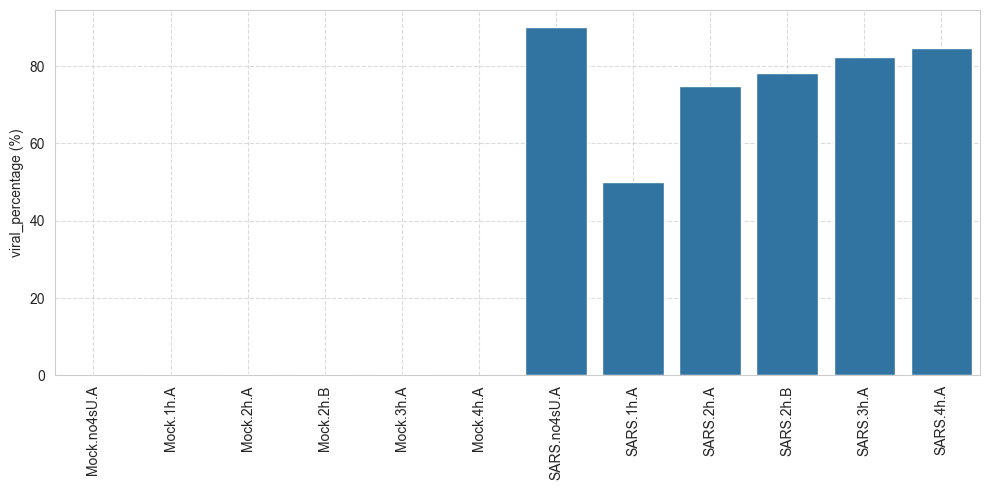

In [33]:
from Py.processing import _compute_expression_percentage
import matplotlib.pyplot as plt
import seaborn as sns

sars = _compute_expression_percentage(sars, name="viral_percentage", genes=(sars.gene_info["Type"]=="viral"))

df = sars.coldata.copy()
df["Sample"] = df.index

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df, x="Sample", y="viral_percentage", ax=ax)
ax.set_axisbelow(True)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.grid(axis="x", linestyle="--", alpha=0.7)
ax.tick_params(axis="x", rotation=90)
plt.subplots_adjust(bottom=0.3)
ax.set_xlabel("")
ax.set_ylabel("viral_percentage (%)")
plt.tight_layout()
plt.show()


Interestingly the 4sU-naive sample shows more viral gene expression, suggesting that 4sU had an effect on viral gene expression.

Since this is such an important control, there is also a specialized plotting built into grandR for that:

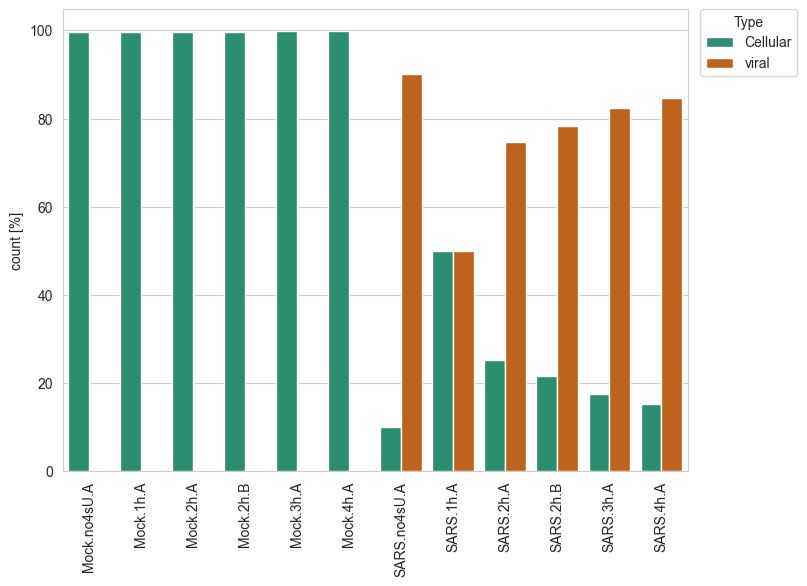

In [34]:
from Py.plot import *

plot_type_distribution(sars, relative=True)

# Bars nicht aufeinander?

There is a column in the `coldata` metadata table that has a special meaning: `Condition`. It is used by many functions as a default, e.g. to plot colors in the PCA or to model kinetics per conditions. It can be accessed by its own function:

In [35]:
sars.condition # Levels ausgabe?

['Mock',
 'Mock',
 'Mock',
 'Mock',
 'Mock',
 'Mock',
 'SARS',
 'SARS',
 'SARS',
 'SARS',
 'SARS',
 'SARS']

and it can be set either directly:

In [36]:
sars = sars.with_coldata("saved", sars.condition)
new_conditions = ["control"] * 6 + ["infected"] * 6
sars = sars.with_condition(new_conditions)
print(sars.coldata)

                      Name Condition  duration.4sU duration.4sU.original  \
Name                                                                       
Mock.no4sU.A  Mock.no4sU.A   control           0.0                 no4sU   
Mock.1h.A        Mock.1h.A   control           1.0                    1h   
Mock.2h.A        Mock.2h.A   control           2.0                    2h   
Mock.2h.B        Mock.2h.B   control           2.0                    2h   
Mock.3h.A        Mock.3h.A   control           3.0                    3h   
Mock.4h.A        Mock.4h.A   control           4.0                    4h   
SARS.no4sU.A  SARS.no4sU.A  infected           0.0                 no4sU   
SARS.1h.A        SARS.1h.A  infected           1.0                    1h   
SARS.2h.A        SARS.2h.A  infected           2.0                    2h   
SARS.2h.B        SARS.2h.B  infected           2.0                    2h   
SARS.3h.A        SARS.3h.A  infected           3.0                    3h   
SARS.4h.A   

or from one or several columns of the metadata (here this is not really reasonable, but there are situations where combining more than one metadata column makes sense):

In [37]:
sars = sars.with_coldata(column="Condition",
    value=(sars.coldata["saved"].astype(str)
        + " "
        + sars.coldata["Replicate"].astype(str)))
print(sars.coldata["Condition"].values)

['Mock A' 'Mock A' 'Mock A' 'Mock B' 'Mock A' 'Mock A' 'SARS A' 'SARS A'
 'SARS A' 'SARS B' 'SARS A' 'SARS A']


In [38]:
sars.coldata["Condition"] = sars.coldata["saved"]
print(sars.coldata["Condition"].tolist())


['Mock A', 'Mock A', 'Mock A', 'Mock B', 'Mock A', 'Mock A', 'SARS A', 'SARS A', 'SARS A', 'SARS B', 'SARS A', 'SARS A']
